In [1]:
from FRDSolverClass import FRDsolver

import numpy as np

In [2]:
#Import all required functions required for the 2D-DRP for this notebook.
#(Running this code block is NOT required if FRD and PSF inputs are generated otherwise

#Note the testfile{}.csv files must be included if generating images with the 2D-DRP

############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/brentbelland/Desktop/Version_028d/2d_PSF_code/'
############################################################
    
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'

# create these directories if they do not exist
import os
for i in [PSF_DIRECTORY,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

# lmfit 
# import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

from Zernike_Module import *

In [3]:
## Set up input images


##Change these values to modify the output

positionvalt = 64
FRDrealt = 0.023
knownFRDlist = np.linspace(0.015,0.030)

##Function defintions to generate images to test with

def get_PSF_parameters(FRDval,Defocusval,Positionval):
    testfile = pd.read_csv("testfile{}.csv".format(Defocusval))
    testfile = testfile.iloc[Positionval]
    testfile['z4':'z22']= testfile['z4':'z22']
    testfile['frd_sigma'] = FRDval
    PSF_parameters = testfile.values
    PSF_parameters = PSF_parameters[:-2]
    return PSF_parameters

def generate_specific_image_position(position,FRD):
    sci_image = 10*np.random.rand(50,50)
    var_image = sci_image
    model3 = LN_PFS_single(sci_image,var_image,dithering=1,save=0,zmax=22,verbosity=0,npix=1536)
    #FRD = 0.015+0.015*np.random.rand()
    res=model3(get_PSF_parameters(FRD,'0',position),return_Image=True) #Position is arbitrarily set by random sci_image input and Neven's code
    In_focus = res[1]

    return In_focus

def generate_image_of_known_FRD(imagetosolve,arrayofFRD,positionvalue):
    imagearrayofFRD = []
    for FRD in arrayofFRD:
        #print(FRD)
        newimage = get_model_image_compare_position(imagetosolve,FRD,positionvalue)
        imagearrayofFRD.append(newimage)
    return imagearrayofFRD

def get_model_image_compare_position(science_image,guessFRD,position):
    #if isinstance(science_image[0][0],list):
    #    print(science_image)
    variance_image = 0.99*science_image+40*np.ones(np.shape(science_image))
    model4 = LN_PFS_single(science_image,variance_image,dithering=1,save=0,zmax=22,verbosity=0,npix=1536,fit_for_flux=True)
    res=model4(get_PSF_parameters(guessFRD,'0',position),return_Image=True) #xy position is fit for by Neven's code
    In_focus = res[1]
    #print(res[-1])
    
    return In_focus

In [13]:
## Generation of the images and FRD list 

newimaget = generate_specific_image_position(positionvalt,FRDrealt) # This is the image to test against.
imagerealt = 500000/np.sum(newimaget)*newimaget #Flux calibration generally corresponding to 50000 counts in brightest image
imagelist = generate_image_of_known_FRD(imagerealt,knownFRDlist,positionvalt)

##Adding noise

def addnoise(image):
    var_image=image+40 #40 accounts for read noise, but keep in mind that the input images must be scaled properly too...
    artificial_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
    for i in range(len(artificial_noise_data)):
        for j in range(len(artificial_noise_data)):
            artificial_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))
    return image+artificial_noise_data

def generate_image_of_known_FRD_noisy(imagetosolve,arrayofFRD,positionvalue):
    imagearrayofFRD = []
    for FRD in arrayofFRD:
        #print(FRD)
        newimage = get_model_image_compare_position(imagetosolve,FRD,positionvalue)
        imagearrayofFRD.append(addnoise(newimage))
    return imagearrayofFRD

imagenoiset = addnoise(imagerealt)
imagelistnoise = generate_image_of_known_FRD_noisy(imagerealt,knownFRDlist,positionvalt)

npix_value:1536


TypeError: __init__() got an unexpected keyword argument 'fit_for_flux'

In [ ]:
#Generate an image with an FRD to solve for, plus a set of known FRD. Takes a long time to run on my computer

FRDimageset = {
    "FRDtofind" : {},
    "knownFRDlist" : {}
}

knownFRDlist = np.linspace(0.015,0.030,10)

for position in range(120):
    FRDimage = generate_specific_image_position(position,FRDrealt)
    FRDimage = 500000/np.sum(FRDimage)*FRDimage
    FRDimageset["FRDtofind"][position] = FRDimage
    FRDimageset["knownFRDlist"][position] = generate_image_of_known_FRD_noisy(FRDimage,knownFRDlist,position)

In [4]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
FRDimageset = load_obj('DetectorFRDs') #Alternatively can load a presaved version across the detector

In [30]:
print(FRDimageset["knownFRDlist"][64])

[array([[ 1.53059805,  4.59012338, 10.67291895, ..., 10.49926544,
        -6.14130376, -6.60639066],
       [-6.00211698,  7.98362342, -0.84043678, ..., -2.40331786,
         6.02584814,  1.02946275],
       [-8.2189243 ,  2.75383142, -2.83568347, ..., -0.58385666,
        12.1423257 ,  1.79470332],
       ...,
       [ 0.913532  , 11.14015106, 13.07499823, ...,  9.81894518,
        -9.2337655 ,  0.02907354],
       [ 1.54832194, 11.51818852,  9.81020048, ...,  1.47064083,
        11.62847505, -4.33513877],
       [ 7.41578654, -1.000104  ,  3.58401232, ...,  5.54808396,
        11.94750574,  1.20480493]]), array([[-0.23140666, -1.93030418,  4.29869607, ..., -1.19520022,
        -1.73433116, -4.64997312],
       [ 3.67438536,  0.87596828, -6.02237662, ..., 14.60110275,
        11.11032432, 15.10429633],
       [-1.75063537, -3.64906908, -0.62202947, ...,  7.73175497,
        -0.45492183,  3.08290842],
       ...,
       [ 3.03684116, -2.82402873, -1.42976878, ...,  2.31177381,
        

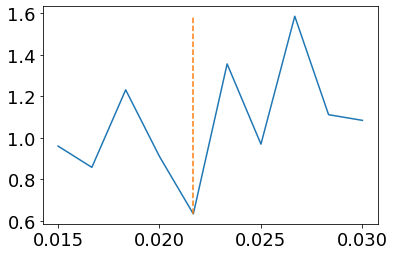

In [11]:
## Example class test

position = 98

knownFRDlist = np.linspace(0.015,0.030,10)

imagelist = np.array(FRDimageset["knownFRDlist"][position])

imagetosolve = FRDimageset["FRDtofind"][position]

testFRD = FRDsolver(knownFRDlist, imagelist, imagetosolve)

(residuallist, minFRD) = testFRD.find_FRD_compare_positions(knownFRDlist, imagelist, imagetosolve)

plt.plot(knownFRDlist,residuallist)
plt.plot([minFRD,minFRD],[np.min(residuallist),np.max(residuallist)],'--')